# AiED - część druga

## Opis problemu i cel badań

**Problem**

Sklasyfikowanie wiadomości przesyłanych pocztą elektroniczną jako spam lub nie-spam. Dane początkowe pochodzą z projektu SpamAssassin i cechuje je wysoka wielowymiarowość oraz stosunkowo niski stosunek dostępnych próbek sklasyfikowanych jako spam do tych poprawnych (dane lekko niezbalansowane).

**Cel i obszar badań**

Zbudowany klasyfikator powinien unikać klasyfikowania listów dobrych jako spam. Stąd jako kryteria jakości (akceptowalności) klasyfikatora przyjmujemy:

* minimalizację stopy błędów 'yes'  →  'no' (FNR)
* przy zapewnieniu stopy błędów 'no'  →  'yes' (FPR) poniżej 0.5%

Zadanie polega na próbie dostrojenia klasyfikatora. Należy w tym celu wykonać serię eksperymentów (sensitivity studies) w celu zbadania jak na skuteczność klasyfikacji wpływa:

1. Algorytm klasyfikatora 
    * (sprawdź np. drzewo decyzyjne, las losowy, MLP, SVM, regresję logistyczną, kNN, naiwnego Bayesa, ...).

2. Parametry klasyfikatora decydujące o jego złożoności (capacity)
    * tu np. możemy zbadać złożoność sieci MLP, parameter C (koszt) w modelu SVM, wysokość drzewa decyzyjnego, itp.

3. Wybór zmiennych / redukcja wymiarowości danych (feature selection) - tu badamy np. następujące metody:
    * metody multivariate (np. RFE),
    * metody feature selection realizowane przez regresję logistyczną (np. forward, backward),
    * PCA (klasyfikacja w oparciu o pierwsze komponenty główne).
4. Metody dla problemów class-imbalanced
    * równoważenie liczności próbek należących do poszczególnych klas (over / under-sampling). Uwaga: równoważymy tylko dane treningowe, dane testowe powinny zachowywać oryginalne proporcje klas.
    * wykorzystanie algorytmu Smote.
5. Zastosowanie niesymetrycznych kosztów błędów: 'yes'  →  'no' i 'no'  →  'yes' w trakcie uczenia klasyfikatora (np. zwiększanie kary za błąd 'yes'  →  'no' powinno poprawić czułość wykrywania spamu kosztem specyficzności, i vice versa).

6. Składanie modeli (ensamble learning) - np. algorytm AdaBoost.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install umap-learn

## Dane wejściowe - wczytanie oraz wstępna analiza

In [ ]:
import pandas as pd
spam_df = pd.read_csv("/content/drive/MyDrive/Colab/AiED/data/spam.dat")
spam_copy_df = spam_df.copy()

Struktura, wielkość oraz statystyki wczytanego zbioru

In [ ]:
print(f"Dataset shape: {spam_df.shape}")
print(spam_df.head(5))
spam_df.describe()

Dataset shape: (4789, 463)
   ACT_NOW  ADDRESSES_ON_CD  ADULT_SITE  ...  X_X_PRESENT  YOUR_INCOME  target
0        0                0           0  ...            0            0     yes
1        0                0           0  ...            0            0      no
2        0                0           0  ...            0            0     yes
3        0                0           0  ...            0            0      no
4        0                0           0  ...            0            0     yes

[5 rows x 463 columns]


,ACT_NOW,ADDRESSES_ON_CD,ADULT_SITE,ADVERT_CODE,ADVERT_CODE2,ALL_CAPS_HEADER,ALL_CAP_PORN,ALL_NATURAL,AMATEUR_PORN,AMAZING,AMAZING_STUFF,AOL_USERS_LINK,APPLY_ONLINE,APPROVED_BY,ASCII_FORM_ENTRY,ASKS_BILLING_ADDRESS,AS_SEEN_ON,BAD_CREDIT,BALANCE_FOR_LONG_20K,BALANCE_FOR_LONG_40K,BANKRUPTCY,BASE64_ENC_TEXT,BEEN_TURNED_DOWN,BEST_PORN,BE_AMAZED,BE_BOSS,BIG_FONT,BILL_1618,BUGGY_CGI,BUGZILLA_BUG,BULK_EMAIL,BUY_DIRECT,CABLE_CONVERTER,CALL_FREE,CALL_NOW,CARRIAGE_RETURNS,CASHCASHCASH,CBYI,CELEBRITY_PORN,CLICK_BELOW,...,USER_AGENT_IMP,USER_AGENT_MACOE,USER_AGENT_MOZILLA_UA,USER_AGENT_MOZILLA_XM,USER_AGENT_MUTT,USER_AGENT_OE,USER_AGENT_OUTLOOK,USER_AGENT_PINE,USER_AGENT_THEBAT,USER_AGENT_TONLINE,USER_IN_WHITELIST,US_DOLLARS,US_DOLLARS_2,US_DOLLARS_3,US_DOLLARS_4,VACATION_SCAM,VERY_SUSP_RECIPS,VIAGRA,VIAGRA_ONLINE,WEB_BUGS,WEIRD_PORT,WE_HONOR_ALL,WE_PROMISE_YOU,WHILE_SUPPLIES,WHILE_YOU_SLEEP,WHY_WAIT,WINNER_CAP,WORK_AT_HOME,WRINKLES,X_ACCEPT_LANG,X_AUTH_WARNING,X_ENC_PRESENT,X_LIBRARY,X_LIST_UNSUBSCRIBE,X_MSMAIL_PRIORITY_HIGH,X_PRECEDENCE_REF,X_PRIORITY_HIGH,X_STORMPOST_TO,X_X_PRESENT,YOUR_INCOME
count,4789.000000,4789.0,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,...,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000,4789.000000
mean,0.008144,0.0,0.006056,0.000209,0.006682,0.000626,0.005638,0.007308,0.001879,0.002088,0.001253,0.001879,0.000835,0.040927,0.003550,0.001253,0.019002,0.010023,0.004385,0.000835,0.000626,0.053665,0.001462,0.003550,0.000835,0.002297,0.117561,0.003550,0.001879,0.009814,0.003759,0.000418,0.001253,0.003550,0.002715,0.007308,0.002715,0.000626,0.001879,0.201712,...,0.003341,0.000209,0.005847,0.039465,0.019628,0.067864,0.013573,0.152224,0.009397,0.002715,0.001462,0.000835,0.002715,0.006473,0.001044,0.000835,0.001879,0.005847,0.002088,0.131760,0.018375,0.008352,0.000209,0.003550,0.002923,0.002923,0.001044,0.006264,0.002923,0.076634,0.315097,0.001044,0.000626,0.012946,0.009397,0.000418,0.019420,0.000835,0.001253,0.000626
std,0.089883,0.0,0.077590,0.014450,0.081478,0.025023,0.074882,0.085185,0.043315,0.045653,0.035377,0.043315,0.028892,0.198142,0.059481,0.035377,0.136546,0.099622,0.066081,0.028892,0.025023,0.225378,0.038208,0.059481,0.028892,0.047876,0.322121,0.059481,0.043315,0.098589,0.061199,0.020434,0.035377,0.059481,0.052036,0.085185,0.052036,0.025023,0.043315,0.401320,...,0.057711,0.014450,0.076248,0.194720,0.138734,0.251538,0.115721,0.359275,0.096489,0.052036,0.038208,0.028892,0.052036,0.080204,0.032298,0.028892,0.043315,0.076248,0.045653,0.338265,0.134319,0.091019,0.014450,0.059481,0.053995,0.053995,0.032298,0.078908,0.053995,0.266038,0.464603,0.032298,0.025023,0.113055,0.096489,0.020434,0.138009,0.028892,0.035377,0.025023
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

Czy dane są niezbalansowane?

In [ ]:
value_counts_df = spam_df['target'].value_counts()
total = len(spam_df.index)
print(value_counts_df)
print(f"Spam samples are {round(value_counts_df['yes'] / total * 100,2)}%\nNot spam samples are {round(value_counts_df['no'] / total * 100,2)}%\nof whole dataset.")

no     2949
yes    1840
Name: target, dtype: int64
Spam samples are 38.42%
Not spam samples are 61.58%
of whole dataset.


## Standaryzacja danych

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
feature_columns = spam_df.columns.difference(['target'], sort=False)
spam_df[feature_columns] = scaler.fit_transform(spam_df[feature_columns])

print("STD && MEAN for plain dataset")
print(f"std -> {spam_copy_df[feature_columns].stack().std()}")
print(f"mean -> {spam_copy_df[feature_columns].stack().mean()}\n")

print("STD && MEAN for standardized dataset")
print(f"std -> {spam_df[feature_columns].stack().std():.3f}")
print(f"mean -> {spam_df[feature_columns].stack().mean()}")

STD && MEAN for plain dataset
std -> 0.1242214007349918
mean -> 0.015676708618867732

STD && MEAN for standardized dataset
std -> 0.991
mean -> -6.098010471698203e-15


## Podział na dane treningowe i testowe

In [ ]:
from sklearn.model_selection import train_test_split

X = spam_df.drop(['target'],axis=1)
y = spam_df.target

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0, test_size=0.33)

print(f"train rows count: {X_train.shape[0]}\ntest rows count: {X_test.shape[0]}")

train rows count: 3208
test rows count: 1581


## Wizualizacja całego zbioru danych w 2D (redukcja cech z wykorzystaniem PCA/UMAP)

In [ ]:
import matplotlib.pyplot as plt

def print_pca_umap(pca_data_df, umap_data_df, title):
    fig, axes = plt.subplots(2, 2)
    fig.suptitle(title, fontsize = 15)
    fig.set_size_inches((20,10))

    clustering_results = { "PCA" : pca_data_df,
                           "UMAP" : umap_data_df
                        }

    for chart_id in range(2):
        for idx, (algo,result_df) in enumerate(clustering_results.items()):
            none_spam_samples = result_df[result_df["target"] == "no"]
            spam_samples = result_df[result_df["target"] == "yes"]
            axes[chart_id][idx].set_xlabel(f"{algo}1")
            axes[chart_id][idx].set_ylabel(f"{algo}2")
            axes[chart_id][idx].set_title(f'2 component {algo}', fontsize=12)
            if chart_id == 0:
                axes[chart_id][idx].scatter(spam_samples['DIM1']
                                ,spam_samples['DIM2']
                                ,c = "red"
                                ,s = 50)
                axes[chart_id][idx].scatter(none_spam_samples['DIM1']
                                ,none_spam_samples['DIM2']
                                ,c = "green"
                                ,s = 25)
                axes[chart_id][idx].legend(["Spam sample", "Non spam sample"])
            else:
                axes[chart_id][idx].scatter(none_spam_samples['DIM1']
                                ,none_spam_samples['DIM2']
                                ,c = "green"
                                ,s = 25)
                axes[chart_id][idx].scatter(spam_samples['DIM1']
                                ,spam_samples['DIM2']
                                ,c = "red"
                                ,s = 50)
                axes[chart_id][idx].legend(["Non spam sample", "Spam sample"])
            axes[chart_id][idx].grid()

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


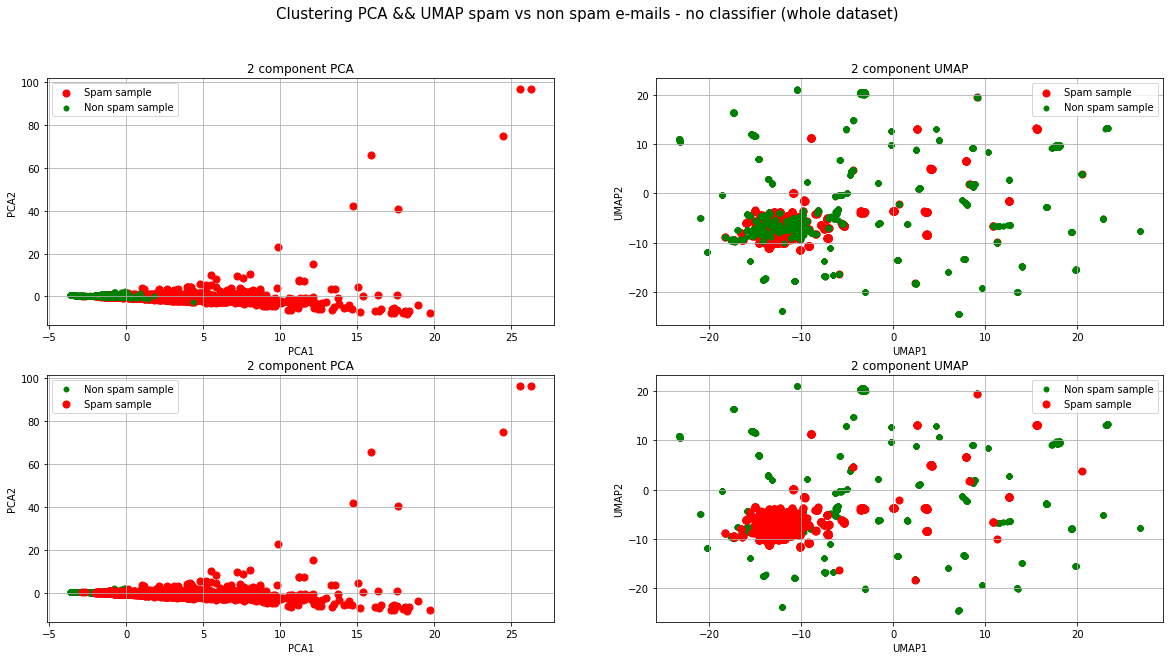

In [ ]:
import umap
from sklearn.decomposition import PCA

pca_components=2
umap_components=2

pca_model = PCA(n_components=pca_components)
umap_model = umap.UMAP(n_components=umap_components)

pca_result = pca_model.fit_transform(X)
umap_result = umap_model.fit_transform(X)

#convert to pandas df with class labels added
pca_result_df = pd.DataFrame(data=pca_result, columns = ['DIM1', 'DIM2'])
pca_result_df = pd.concat([pca_result_df, spam_df["target"]], axis=1)
umap_result_df = pd.DataFrame(data=umap_result, columns = ['DIM1', 'DIM2'])
umap_result_df = pd.concat([umap_result_df, spam_df["target"]], axis=1)

print_pca_umap(pca_result_df,umap_result_df,"Clustering PCA && UMAP spam vs non spam e-mails - no classifier (whole dataset)")

Jak widać na utworzonych wykresach, oba algorytmy redukując liczbę wymiarów do dwóch średnio radzą sobie z klasteryzacją nieprzetworzonych danych i mają problemy z jasną separacją próbek oznaczonych jako spam od tych prawidłowych.

Wykreślono 4 wykresy, ponieważ kolejność w jakiej wyświetlamy/kolorujemy próbki ma znaczenie dla analizowanego zbioru. Porównując grafiki dolne z górnymi widzimy, że w zależności od kolejności wyświetlania i kolorowania(legenda), próbki znacząco na siebie nachodzą i w dwóch wymiarach ciężko jest zauważyć problem nakładających się danych. 

Dodatkowo biorą pod uwagę tylko jedną kolejność kolorowania punktów (w szczególności na wykresie PCA) wydawać byłoby się mogło, że ilość próbek, które są spamem znacznie przekracza ilość nie spamu, gdzie w rzeczywistości jest odwrotnie.

Zuważyć również można, że algorytm PCA skupiał się na grupowaniu danych, które nie są spamem natomiast UMAP koncentrował się na odwrotnej klasteryzacji.

## Badanie skuteczności wybranych modeli

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
from dataclasses import dataclass
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

@dataclass
class StatistictsData:
    """ Helper class for storing most important statistics"""
    name: str
    accuracy: float
    sensitivity: float
    specificity: float
    FNR: float
    FPR: float

def calculate_statistics(y_test, y_pred, print_results=False):
    """Helper function for easier most important statistics calculation and printing"""
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp) * 100
    sensitivity = tp / (tp + fn) * 100
    fnr = fn / (fn + tp) * 100
    fpr = fp / (fp + tn) * 100
    accuracy = accuracy_score(y_test, y_pred) * 100

    if(print_results):
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        plt.show()
        print(f"accuracy = {accuracy:.2f}%\nsensitivity = {sensitivity:.2f}%\nspecificity = {specificity:.2f}%\nFNR = {fnr:.2f}%\nFPR = {fpr:.2f}%")
    else:
        return accuracy, sensitivity, specificity, fnr, fpr


def plot_confusion_matrix(y_test, y_pred, stat_name, stats_container, labels, ax, index):
    """Helper function for ploting the confusion matrix"""
    stats = calculate_statistics(y_test, y_pred)
    stats_data = StatistictsData(stat_name,*stats)
    stats_container.append(stats_data)
    cf_matrix = confusion_matrix(y_test, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(cf_matrix, display_labels=labels)
    disp.plot(ax=ax)
    disp.ax_.set_title(stat_name)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if index!=0:
        disp.ax_.set_ylabel('')
    return disp


plot_style = {"marker": '^', "linestyle": '--'}

def plot_stats(ax, range, stats, tick_base=None):
    """Helper function for ploting stats on chart"""
    ax.plot(range, stats["accuracy"], label="accuracy", **plot_style)
    ax.plot(range, stats["sensitivity"], label="sensitivity", **plot_style)
    ax.plot(range, stats["specificity"], label="specificity", **plot_style)
    ax.grid(b=True)
    ax.legend()
    if tick_base:
        loc = plticker.MultipleLocator(base=tick_base)
        ax.xaxis.set_major_locator(loc)

def print_max_stats(stats):
    print(f"Max accuracy: {stats['accuracy'].max():.3f}%\nMax sensivity: {stats['sensitivity'].max():.3f}%\nMax specificity: {stats['specificity'].max():.3f}%")

### Wybranie najlepszych dwóch bazowych klasyfikatorów do analizy

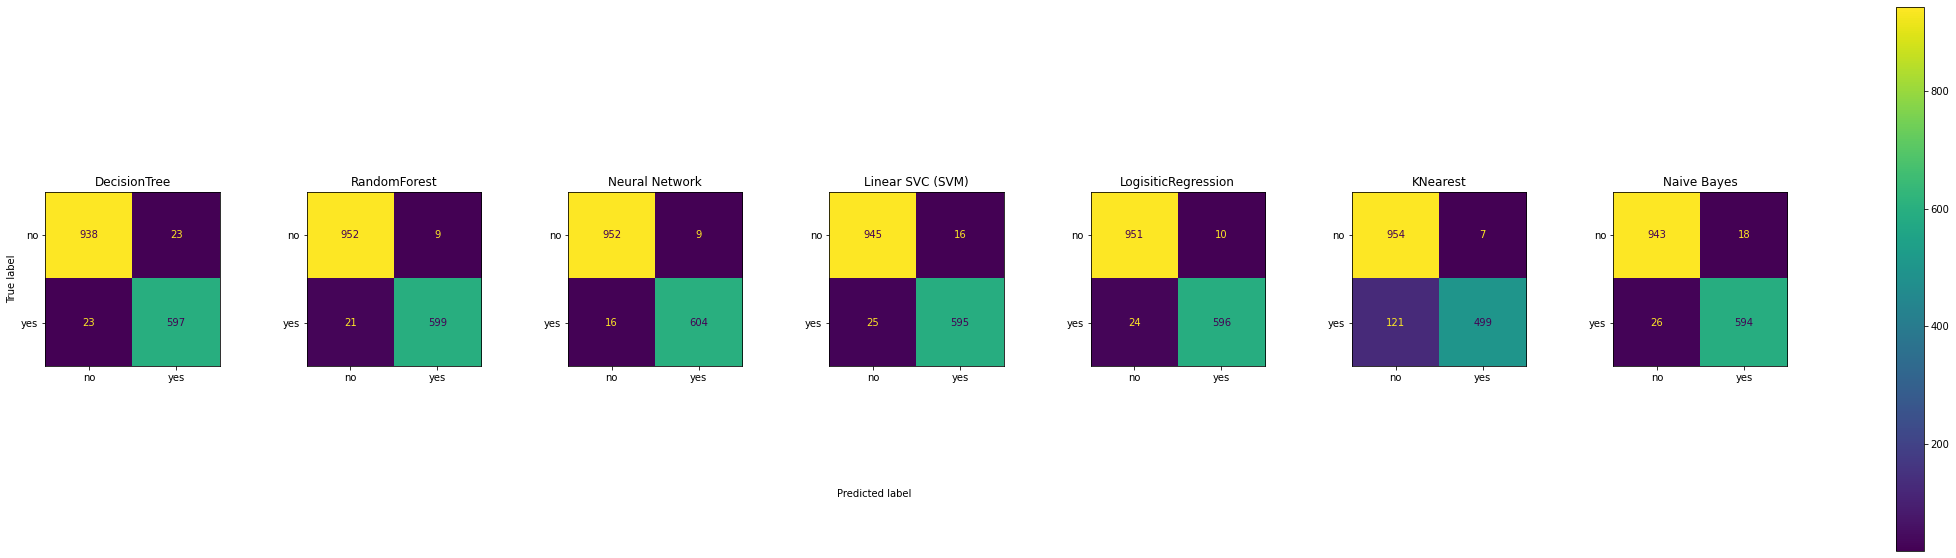

,classfier name,accuracy,sensitivity,specificity,FNR,FPR
0,DecisionTree,97.090449,96.290323,97.606660,3.709677,2.393340
1,RandomForest,98.102467,96.612903,99.063476,3.387097,0.936524
2,Neural Network,98.418722,97.419355,99.063476,2.580645,0.936524
3,Linear SVC (SVM),97.406705,95.967742,98.335068,4.032258,1.664932
4,LogisiticRegression,97.849462,96.129032,98.959417,3.870968,1.040583
5,KNearest,91.903858,80.483871,99.271592,19.516129,0.728408
6,Naive Bayes,97.216951,95.806452,98.126951,4.193548,1.873049


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# classifiers with default scikit-learn settings
classifiers = {
    "DecisionTree": DecisionTreeClassifier(random_state=0),
    "RandomForest": RandomForestClassifier(random_state=0),
    "Neural Network": MLPClassifier(random_state=0),
    "Linear SVC (SVM)": LinearSVC(random_state=0, dual=False),
    "LogisiticRegression": LogisticRegression(random_state=0),
    "KNearest": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
}

classifiers_stats = []

f, axes = plt.subplots(1, len(classifiers), figsize=(40, 10))

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    disp = plot_confusion_matrix(y_test,y_pred,key,classifiers_stats,classifier.classes_,axes[i],i)

classifiers_stats_df = pd.DataFrame(classifiers_stats)
classifiers_stats_df.rename(columns={'name':'classfier name'}, inplace=True)

f.text(0.4, 0.2, 'Predicted label', ha='left')

f.colorbar(disp.im_, ax=axes)
plt.show()
classifiers_stats_df

#### Wnioski

* Wysoka dokładność modelu nie zawsze oznacza poprawne działanie modelu dla danych niezbalansowanych.
* Niska czułość modelu wskazuje na dużą liczbę próbek, które były spamem a zostały sklasyfiikowane jako dobre wiadomości
* Przedstawione 7 klasyfikatorów, które nauczone zostały wyłącznie z podstawowymi parametrami, pokazują korelację pomiędzy dokładnością (accuracy) i czułością (sensitivity). Widać również też jak parametry te przekładają się na wartości FNR i FPR. 
* W zadaniu staramy się zachować poziom FPR w okolicy wartości 0.5% i dążyć do minimalizacji wartości FNR. Najniższy poziom FPR osiągnął klasyfikator KNN natomiast odbiło się to znacznie na wartości FNR oraz dokładności tego modelu. Porównując wartość 'yes' -> 'no' dla modelu KNN z innymi klasyfikatorami widzimy, że wypada on najgorzej.
* Względnie najlepsze wyniki przy bazowych parametrach uzyskano z wykorzystaniem klasyfikatorów opartych o **drzewa losowe** oraz **sieć neuronową**, dlatego te 2 klasyfikatory zostaną poddane dalszej analizie*.

\* - z uwagi na niezbalansowane dane i porównanie klasyfikatorów wyłącznie w oparciu o ich bazowe parametry, może okazać się, że któryś z niewybranych modeli osiągnie znacznie lepsze rezultaty po jego poprawnym dostrojeniu lub zbalansowaniu danych.

### 1. Las losowy

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def run_random_forest(X_train, X_test, y_train, **estimator_params):
    random_forest_clf = RandomForestClassifier(random_state=0, **estimator_params)
    y_pred = random_forest_clf.fit(X_train, y_train).predict(X_test)
    return y_pred

#### Wersja podstawowa

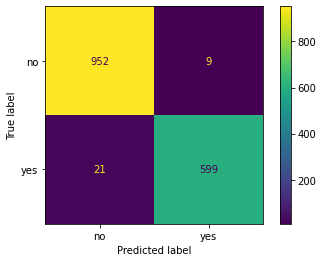

accuracy = 98.10%
sensitivity = 96.61%
specificity = 99.06%
FNR = 3.39%
FPR = 0.94%


In [ ]:
y_pred = run_random_forest(X_train, X_test, y_train)
calculate_statistics(y_test, y_pred, True)

#### Parametry klasyfikatora


##### Liczba estymatorów, maksymalna głębokość, maksymalna liczba cech

In [ ]:
statistics_depth = [] # 5 10 15 20 25 30 35 40 45 50 
statistics_features = [] # 5 10 15 20 25 30 35 40 45 50 
statistics_estimators_count = [] # 50 100 150 200 250 300 350 400 450 500

def random_forest_evaluation(current_range,clf_statistics_list, **clf_params):
    y_pred = run_random_forest(X_train, X_test, y_train, **clf_params)
    stats = calculate_statistics(y_test, y_pred)
    clf_stats = StatistictsData(current_range,*stats)
    clf_statistics_list.append(clf_stats)

common_range = range(5, 51, 5)

for size in common_range:
    # depth
    random_forest_evaluation(size, statistics_depth, max_depth=size)
    # max features
    random_forest_evaluation(size, statistics_features, max_features=size)
    # estimators count
    random_forest_evaluation(size, statistics_estimators_count, n_estimators=size * 10)

statistics_depth_df = pd.DataFrame(statistics_depth)
statistics_depth_df.rename(columns={'name':'max depth of forest'}, inplace=True)
statistics_features_df = pd.DataFrame(statistics_features)
statistics_features_df.rename(columns={'name':'max number of features'}, inplace=True)
statistics_estimators_count_df = pd.DataFrame(statistics_estimators_count)
statistics_estimators_count_df.rename(columns={'name':'Number of esimators'}, inplace=True)
statistics_estimators_count_df["Number of esimators"] *= 10
grouped_stats_dfs = [statistics_depth_df, statistics_features_df, statistics_estimators_count_df]

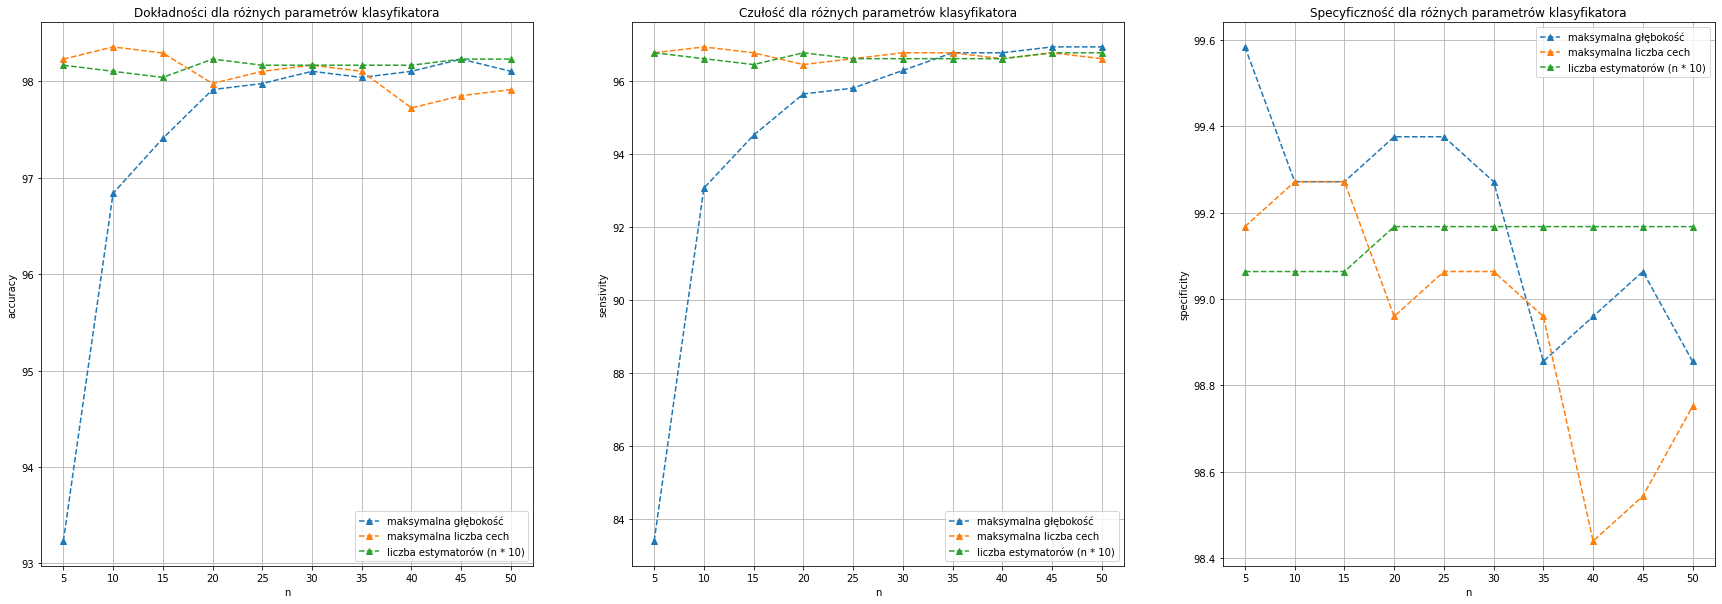

Max values for max depth parameter
Max accuracy: 98.229%
Max sensivity: 96.935%
Max specificity: 99.584%
Max values for max features parameter
Max accuracy: 98.355%
Max sensivity: 96.935%
Max specificity: 99.272%
Max values for estimators count parameter
Max accuracy: 98.229%
Max sensivity: 96.774%
Max specificity: 99.168%


In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(30,10))

def plot_grouped_stats(ax, stats, stat_name):
    ax.plot(common_range, stats[0][stat_name], label="maksymalna głębokość", **plot_style)
    ax.plot(common_range, stats[1][stat_name], label="maksymalna liczba cech", **plot_style)
    ax.plot(common_range, stats[2][stat_name], label="liczba estymatorów (n * 10)", **plot_style)
    ax.grid(b=True)
    ax.legend()

for i,stat_name in enumerate(["accuracy", "sensitivity", "specificity"]):
    plot_grouped_stats(axs[i], grouped_stats_dfs, stat_name)

axs[0].set(xlabel='n', ylabel='accuracy',
        title='Dokładności dla różnych parametrów klasyfikatora')
axs[1].set(xlabel='n', ylabel='sensivity',
        title='Czułość dla różnych parametrów klasyfikatora')
axs[2].set(xlabel='n', ylabel='specificity',
        title='Specyficzność dla różnych parametrów klasyfikatora')


loc = plticker.MultipleLocator(base=5.0)
for ax in axs:
    ax.xaxis.set_major_locator(loc)

plt.show()

for i,stat_df in enumerate(grouped_stats_dfs):
    if i == 0:
        print("Max values for max depth parameter")
    elif i == 1:
        print("Max values for max features parameter")
    elif i == 2:
        print("Max values for estimators count parameter")
    print_max_stats(stat_df)

In [ ]:
from IPython.display import display

display(statistics_depth_df)
display(statistics_features_df)
display(statistics_estimators_count_df)

,max depth of forest,accuracy,sensitivity,specificity,FNR,FPR
0,5,93.232132,83.387097,99.583767,16.612903,0.416233
1,10,96.837445,93.064516,99.271592,6.935484,0.728408
2,15,97.406705,94.516129,99.271592,5.483871,0.728408
3,20,97.912713,95.645161,99.375650,4.354839,0.624350
4,25,97.975965,95.806452,99.375650,4.193548,0.624350
5,30,98.102467,96.290323,99.271592,3.709677,0.728408
6,35,98.039216,96.774194,98.855359,3.225806,1.144641
7,40,98.102467,96.774194,98.959417,3.225806,1.040583
8,45,98.228969,96.935484,99.063476,3.064516,0.936524
9,50,98.102467,96.935484,98.855359,3.064516,1.144641


,max number of features,accuracy,sensitivity,specificity,FNR,FPR
0,5,98.228969,96.774194,99.167534,3.225806,0.832466
1,10,98.355471,96.935484,99.271592,3.064516,0.728408
2,15,98.292220,96.774194,99.271592,3.225806,0.728408
3,20,97.975965,96.451613,98.959417,3.548387,1.040583
4,25,98.102467,96.612903,99.063476,3.387097,0.936524
5,30,98.165718,96.774194,99.063476,3.225806,0.936524
6,35,98.102467,96.774194,98.959417,3.225806,1.040583
7,40,97.722960,96.612903,98.439126,3.387097,1.560874
8,45,97.849462,96.774194,98.543184,3.225806,1.456816
9,50,97.912713,96.612903,98.751301,3.387097,1.248699


,Number of esimators,accuracy,sensitivity,specificity,FNR,FPR
0,50,98.165718,96.774194,99.063476,3.225806,0.936524
1,100,98.102467,96.612903,99.063476,3.387097,0.936524
2,150,98.039216,96.451613,99.063476,3.548387,0.936524
3,200,98.228969,96.774194,99.167534,3.225806,0.832466
4,250,98.165718,96.612903,99.167534,3.387097,0.832466
5,300,98.165718,96.612903,99.167534,3.387097,0.832466
6,350,98.165718,96.612903,99.167534,3.387097,0.832466
7,400,98.165718,96.612903,99.167534,3.387097,0.832466
8,450,98.228969,96.774194,99.167534,3.225806,0.832466
9,500,98.228969,96.774194,99.167534,3.225806,0.832466


##### Wnioski

* Do największej zmian dokładności i czułości dochodzi, gdy modyfikujemy parameter odpowiadająćy głębokości lasu.
*  Zarówno dokładność jak i czułość są wyższe dla mniejszej ilości cech w stosunku do liczby estymatorów w lesie, lecz wraz z wzrostem liczby estymatorów i cech dochodzi do odwrotnej sytuacji.
* Największą specyficzność modelu możemy uzyskać modyfikując maksymalną głębokość drzewa lecz odbywa się to znaczym zmniejszeniem czułości i dokładności.

##### Kryterium podziału

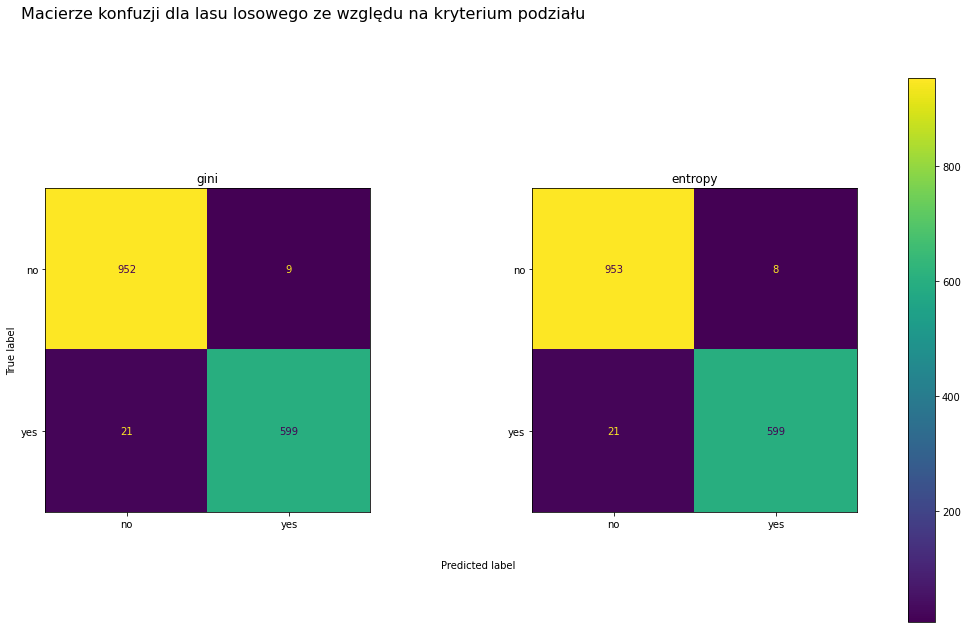

,name,accuracy,sensitivity,specificity,FNR,FPR
0,gini,98.102467,96.612903,99.063476,3.387097,0.936524
1,entropy,98.165718,96.612903,99.167534,3.387097,0.832466


In [ ]:
classifiers_stats = []

f, axes = plt.subplots(1, 2, figsize=(20, 10))

for i, criterion in enumerate(["gini", "entropy"]):
    y_pred = run_random_forest(X_train, X_test, y_train, criterion=criterion)
    disp = plot_confusion_matrix(y_test,y_pred,criterion,classifiers_stats,["no","yes"],axes[i],i)

classifiers_stats_df = pd.DataFrame(classifiers_stats)

f.text(0.4, 0.2, 'Predicted label', ha='left')
f.colorbar(disp.im_, ax=axes)
f.suptitle('Macierze konfuzji dla lasu losowego ze względu na kryterium podziału', fontsize=16, ha="right")
plt.show()
classifiers_stats_df

##### Wnioski

* Zmiana kryterium podziału na entropię pozwoliła lepiej sklasyfikować jeden przypadek, dzięki czemu dążymy do minimalizacji wartości FPR.

#### Selekcja cech

#### Metoda multivariate RFECV i Forward feature selection

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFECV, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

n_features = 5

rfecv = RFECV(
    estimator=GradientBoostingClassifier(random_state=0),
    min_features_to_select=n_features,
    step=10
)
sfs = SequentialFeatureSelector(LogisticRegression(random_state=0), 
                                n_features_to_select=n_features,
                                direction='forward',
                                )

X_rfe = pd.DataFrame(rfecv.fit_transform(X, y))
X_rfe.columns = rfecv.get_feature_names_out()

X_sfs = pd.DataFrame(sfs.fit_transform(X, y))
X_sfs.columns = sfs.get_feature_names_out()

print(f"Number of features to keep based on RFECV: {rfecv.n_features_}")
print(f"Top {n_features} features selected by LogisticRegression forward sequential selection:{list(X.columns[sfs.get_support()])}")

reduced_datasets = {
    "RFECV": train_test_split(X_rfe,y,random_state=0, test_size=0.33),
    "Forward feature selection": train_test_split(X_sfs,y,random_state=0, test_size=0.33)
}

Number of features to keep based on RFECV: 102
Top 5 features selected by LogisticRegression forward sequential selection:['CTYPE_JUST_HTML', 'RESENT_TO', 'SPAM_PHRASE_00_01', 'SPAM_PHRASE_01_02', 'SPAM_PHRASE_02_03']


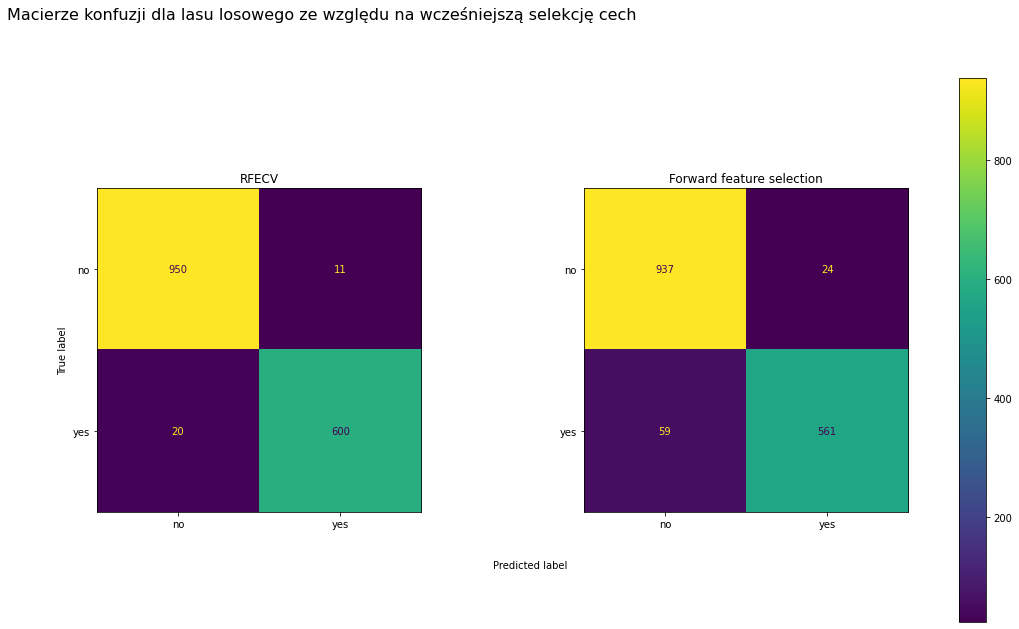

,Feature selection method,accuracy,sensitivity,specificity,FNR,FPR
0,RFECV,98.039216,96.774194,98.855359,3.225806,1.144641
1,Forward feature selection,94.750158,90.483871,97.502601,9.516129,2.497399


In [ ]:
classifiers_stats = []

f, axes = plt.subplots(1, 2, figsize=(20, 10))

for i, (name,dataset) in enumerate(reduced_datasets.items()):
    X_train_dataset, X_test_dataset, y_train_dataset, y_test_dataset = dataset
    y_pred = run_random_forest(X_train_dataset, X_test_dataset, y_train_dataset)
    disp = plot_confusion_matrix(y_test_dataset,y_pred,name,classifiers_stats,["no","yes"],axes[i],i)

classifiers_stats_df = pd.DataFrame(classifiers_stats)
classifiers_stats_df.rename(columns={'name':'Feature selection method'}, inplace=True)

f.text(0.4, 0.2, 'Predicted label', ha='left')
f.colorbar(disp.im_, ax=axes)
f.suptitle('Macierze konfuzji dla lasu losowego ze względu na wcześniejszą selekcję cech', fontsize=16, ha="right")
plt.show()
classifiers_stats_df

#### Metoda PCA

In [ ]:
from sklearn.decomposition import PCA

sizes = range(50,463,50)
pca_datasets = {}

for size in sizes:
    pca = PCA(n_components=size)
    X_pca = pd.DataFrame(pca.fit_transform(X, y))
    pca_datasets[size] = train_test_split(X_pca,y,random_state=0, test_size=0.33)

In [ ]:
pca_stats = []

for (pca_size,pca_dataset) in pca_datasets.items():
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = pca_dataset
    y_pred = run_random_forest(X_train_pca, X_test_pca, y_train_pca)
    stats = calculate_statistics(y_test_pca,y_pred)
    pca_model_data = StatistictsData(pca_size,*stats)
    pca_stats.append(pca_model_data)

pca_stats_df = pd.DataFrame(pca_stats)
pca_stats_df.rename(columns={'name':'Number of features'}, inplace=True)

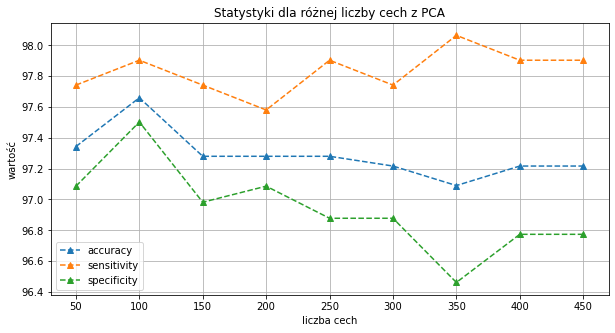

Max accuracy: 97.660%
Max sensivity: 98.065%
Max specificity: 97.503%


,Number of features,accuracy,sensitivity,specificity,FNR,FPR
0,50,97.343454,97.741935,97.086368,2.258065,2.913632
1,100,97.659709,97.903226,97.502601,2.096774,2.497399
2,150,97.280202,97.741935,96.982310,2.258065,3.017690
3,200,97.280202,97.580645,97.086368,2.419355,2.913632
4,250,97.280202,97.903226,96.878252,2.096774,3.121748
5,300,97.216951,97.741935,96.878252,2.258065,3.121748
6,350,97.090449,98.064516,96.462019,1.935484,3.537981
7,400,97.216951,97.903226,96.774194,2.096774,3.225806
8,450,97.216951,97.903226,96.774194,2.096774,3.225806


In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

plot_stats(ax, sizes, pca_stats_df, tick_base=50)

ax.set(xlabel='liczba cech', ylabel='wartość',
       title='Statystyki dla różnej liczby cech z PCA')

plt.show()
print_max_stats(pca_stats_df)
pca_stats_df

##### Wnioski

* Metoda RFECV z pośród 463 cech uznała 102 za najważniejsze dla przeprowadzanej analizy.
* Dla metody forward feature selection wybrano tylko 5 cech, ponieważ dla dużej ilości cech wykonuje się ona znacznie dłużej.
* Selekcja cech dokonana metodą RFECV, dla lasu losowego nie wpływa znacząco na czułość klasyfikatora. Prowadzi do podwyższenia parametru FPR, zmniejsza nieznacznie ilość decyzcji 'yes' -> 'no', natomiast zwiększa wartość 'no' -> 'yes'.
* Selekcja cech metodą forward feature selection dla 5 cech generuje znacznie gorsze rezultaty, wynika to z zbyt małej liczby cech uzwględnianych podczas ewaluacji modelu.
* Dla metody wyznaczania komponentów głównych dokładność i specyficzność modelu maleją wraz z wzrostem ilości analizowanych cech, natomiast czułość rośnie.

#### Równoważenie treningowego zbioru danych

In [ ]:
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.cluster import KMeans
from collections import Counter

kmeans = KMeans(random_state=0,n_init=5,max_iter=150)

samplers = {
    "RandomUnderSampler": RandomUnderSampler(random_state=0),
    "ClusterCentroids": ClusterCentroids(random_state=0, estimator=kmeans),
    "RandomOverSampler": RandomOverSampler(random_state=0),
    "SMOTE": SMOTE(random_state=0),
    "ADASYN": ADASYN(random_state=0),
    "SMOTEENN": SMOTEENN(random_state=0),
    "SMOTETomek": SMOTETomek(random_state=0)
}

sampled_datasets = {}

for i, (key, sampler) in enumerate(samplers.items()):
    sampled_datasets[key] = sampler.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/imblearn/under_sampling/_prototype_generation/_cluster_centroids.py:172: ConvergenceWarning: Number of distinct clusters (766) found smaller than n_clusters (1220). Possibly due to duplicate points in X.
  self.estimator_.fit(_safe_indexing(X, target_class_indices))


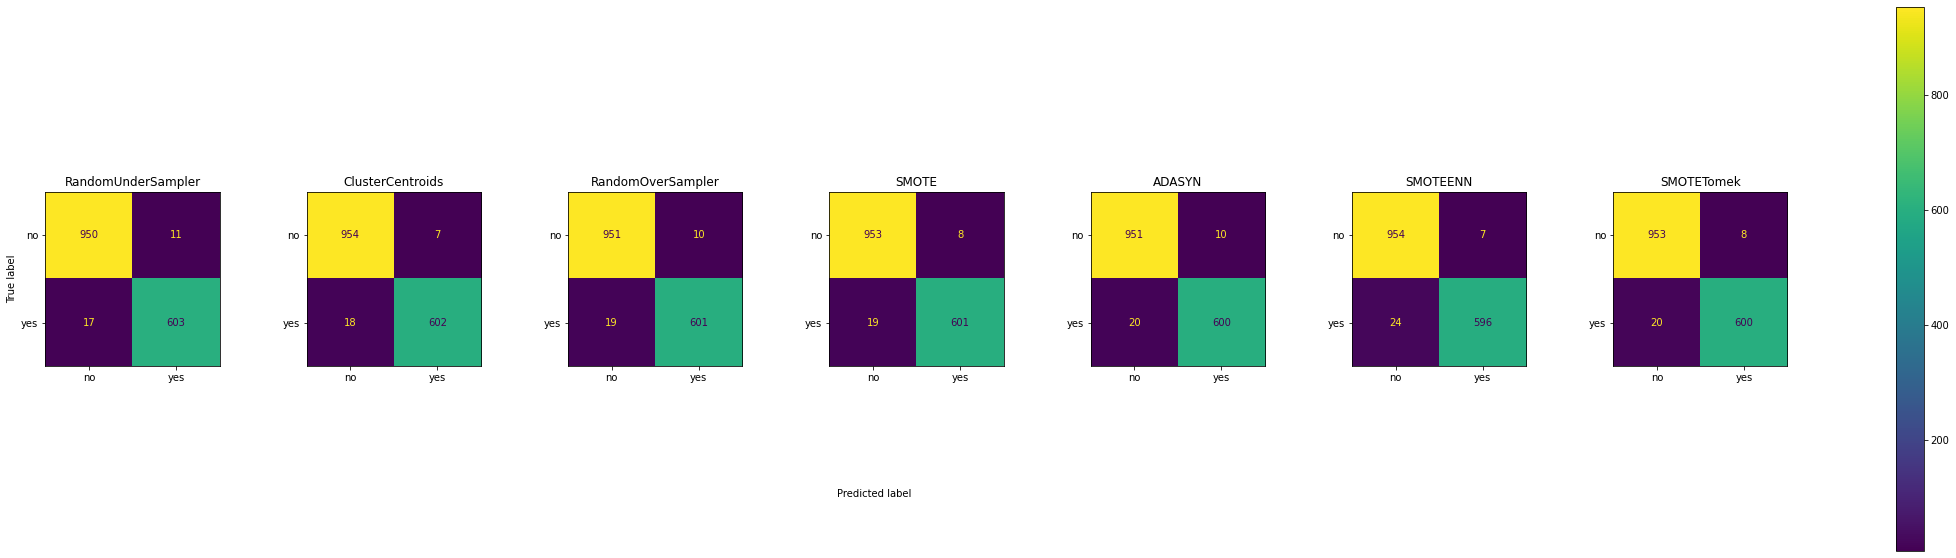

,name,accuracy,sensitivity,specificity,FNR,FPR
0,RandomUnderSampler,98.228969,97.258065,98.855359,2.741935,1.144641
1,ClusterCentroids,98.418722,97.096774,99.271592,2.903226,0.728408
2,RandomOverSampler,98.165718,96.935484,98.959417,3.064516,1.040583
3,SMOTE,98.292220,96.935484,99.167534,3.064516,0.832466
4,ADASYN,98.102467,96.774194,98.959417,3.225806,1.040583
5,SMOTEENN,98.039216,96.129032,99.271592,3.870968,0.728408
6,SMOTETomek,98.228969,96.774194,99.167534,3.225806,0.832466


In [ ]:
samplers_stats = []

f, axes = plt.subplots(1, len(sampled_datasets), figsize=(40, 10))

for i, (key, dataset) in enumerate(sampled_datasets.items()):
    X_train_under, y_train_under = dataset
    y_pred = run_random_forest(X_train_under, X_test, y_train_under)
    disp = plot_confusion_matrix(y_test,y_pred,key,samplers_stats,["no","yes"],axes[i],i)

samplers_stats_df = pd.DataFrame(samplers_stats)

f.text(0.4, 0.2, 'Predicted label', ha='left')

f.colorbar(disp.im_, ax=axes)
plt.show()
samplers_stats_df

##### Wnioski

* Każde z metod balansowania pozwoliło na dodatkowe poprawne sklasyfikowanie przez las losowy około 20 próbek w stosunku do uruchomienia tego modelu na niezmodyfikowanym zbiorze danych.
* Korekcja zbioru danych pozwoliła znacznie podnieść wartość czułości oraz specyficzności, nie obniżając mocno dokładności klasyfikacji tak jak miało to miejsce w poprzednich eksperymentach.
* Najlepszy wynik uzyskano dla algorytmu ClusterCentroids (nawet gdy ilość przebiegów klasteryzacji i iteracji zostały zmniejszone o połowę [ze względu na długi czas wykonywania]). Dalsze dostrojenie parameterów klasteryzacji powinno pzynieść jeszcze lepsze wyniki.
* Zastosowanie algorytmu SMOTEENN, który dokonuje zarówno under samplingu jak i over samplingu przynosi rezultaty zbliżone do metody ClusterCentroids i trwa znacznie krócej.

#### Niesymetryczne koszty błędu

In [ ]:
weights = range(1, 10)
weight_statisticts = [] 

for weight in weights:
    y_pred = run_random_forest(X_train, X_test, y_train, class_weight={"no": 1, "yes": weight} )
    stats = calculate_statistics(y_test,y_pred)
    data = StatistictsData(weight,*stats)
    weight_statisticts.append(data)

weight_statisticts_df = pd.DataFrame(weight_statisticts)
weight_statisticts_df.rename(columns={'name':'Weight of spam samples'}, inplace=True)

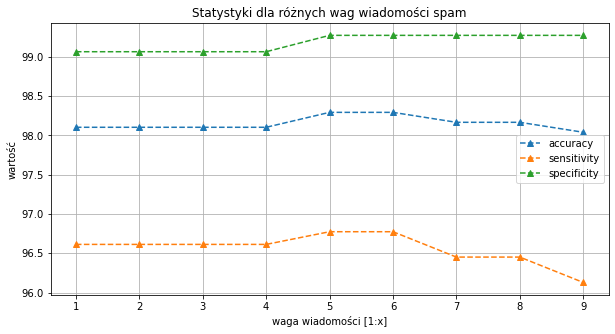

Max accuracy: 98.292%
Max sensivity: 96.774%
Max specificity: 99.272%


,Weight of spam samples,accuracy,sensitivity,specificity,FNR,FPR
0,1,98.102467,96.612903,99.063476,3.387097,0.936524
1,2,98.102467,96.612903,99.063476,3.387097,0.936524
2,3,98.102467,96.612903,99.063476,3.387097,0.936524
3,4,98.102467,96.612903,99.063476,3.387097,0.936524
4,5,98.292220,96.774194,99.271592,3.225806,0.728408
5,6,98.292220,96.774194,99.271592,3.225806,0.728408
6,7,98.165718,96.451613,99.271592,3.548387,0.728408
7,8,98.165718,96.451613,99.271592,3.548387,0.728408
8,9,98.039216,96.129032,99.271592,3.870968,0.728408


In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

plot_stats(ax,weights,weight_statisticts_df)

ax.set(xlabel='waga wiadomości [1:x]', ylabel='wartość',
       title='Statystyki dla różnych wag wiadomości spam')

plt.show()
print_max_stats(weight_statisticts_df)
weight_statisticts_df

##### Wnioski

* Znaczne zwiększenie wagi próbek, które są zaklasyfikowane jako spam obniża czułość modelu, natomiast zwiększa specyficzność.
* Dokładność modelu niezależnie od wagi oscyluje w tym samym poziomie.
* Manipulacja kosztem błędów pomaga nieznacznie poprawić każdą z badanych metryk, przykładowo dla wagi 6 otrzymujemy największe wartości dla każdego z wymiarów.

#### Składanie modeli

Analizowany las losowy jest typem uśrednienia wyniku podczas składania modeli dlatego poniżej przeprowadzono składanie klasyfikatorów z wykorzystaniem algorytmu AdaBoost z bazowym modelem drzewa decyzyjnego.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

statistics_adaboost = []
clf_range = range(50, 501, 50)

for n_trees in clf_range:
    clf = AdaBoostClassifier(DecisionTreeClassifier(random_state=0), n_estimators=n_trees, random_state=0)
    y_pred_adaboost = clf.fit(X_train, y_train).predict(X_test)
    stats = calculate_statistics(y_test, y_pred_adaboost)
    clf_stats = StatistictsData(n_trees,*stats)
    statistics_adaboost.append(clf_stats)

statistics_adaboost_df = pd.DataFrame(statistics_adaboost)
statistics_adaboost_df.rename(columns={'name':'Number of trees'}, inplace=True)

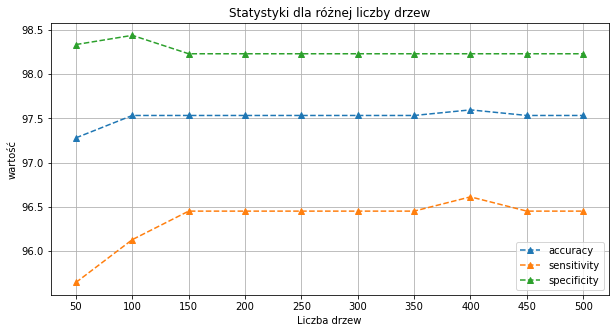

Max accuracy: 97.596%
Max sensivity: 96.613%
Max specificity: 98.439%


,Number of trees,accuracy,sensitivity,specificity,FNR,FPR
0,50,97.280202,95.645161,98.335068,4.354839,1.664932
1,100,97.533207,96.129032,98.439126,3.870968,1.560874
2,150,97.533207,96.451613,98.231009,3.548387,1.768991
3,200,97.533207,96.451613,98.231009,3.548387,1.768991
4,250,97.533207,96.451613,98.231009,3.548387,1.768991
5,300,97.533207,96.451613,98.231009,3.548387,1.768991
6,350,97.533207,96.451613,98.231009,3.548387,1.768991
7,400,97.596458,96.612903,98.231009,3.387097,1.768991
8,450,97.533207,96.451613,98.231009,3.548387,1.768991
9,500,97.533207,96.451613,98.231009,3.548387,1.768991


In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

plot_stats(ax,clf_range,statistics_adaboost_df,50.0)

ax.set(xlabel='Liczba drzew', ylabel='wartość',
       title='Statystyki dla różnej liczby drzew')

plt.show()
print_max_stats(statistics_adaboost_df)
statistics_adaboost_df

##### Wnioski

* Wykorzystanie algorytmu AdaBoost z modelem drzewa decyzyjnego dla każdej liczby estymatorów nie dało lepszych wyników niż bazowa wersja lasu losowego.
* Wszystkie metryki stabilizują się przy 150 drzewach w algorytmie i dalsze zwiększenie parameteru nie przynosi większej poprawy.
* Składanie klasyfikatorów pozwala nieznacznie zwiększyć każdą z statystyk bazowego modelu.

### 1. Sieć neuronowa

In [ ]:
from sklearn.neural_network import MLPClassifier

def run_mlp(X_train, X_test, y_train, **mlp_params):
    mlp_clf = MLPClassifier(random_state=0, max_iter=300, **mlp_params)
    y_pred = mlp_clf.fit(X_train, y_train).predict(X_test)
    return y_pred

#### Wersja podstawowa

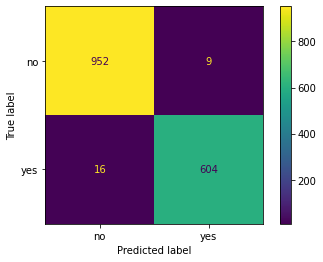

accuracy = 98.42%
sensitivity = 97.42%
specificity = 99.06%
FNR = 2.58%
FPR = 0.94%


In [ ]:
y_pred = run_mlp(X_train, X_test, y_train)
calculate_statistics(y_test, y_pred, True)

#### Parametry klasyfikatora

##### Liczba warstw ukrytych, liczba neuronów w warstwie ukrytej

In [ ]:
statistics_hidden_layers = [] # 1 2 3 4 5 6 7 8 9 10
statistics_n_neurons = [] # 100 200 300 400 500 600 700 800 900 1000

def mlp_evaluation(current_range,clf_statistics_list, **clf_params):
    y_pred = run_mlp(X_train, X_test, y_train, **clf_params)
    stats = calculate_statistics(y_test, y_pred)
    clf_stats = StatistictsData(current_range,*stats)
    clf_statistics_list.append(clf_stats)

common_range = range(1, 11, 1)

for size in common_range:
    # hidden layer size
    mlp_evaluation(size, statistics_hidden_layers, hidden_layer_sizes=(100,)*size)
    # neurons in 1 layer
    mlp_evaluation(size*100, statistics_n_neurons, hidden_layer_sizes=(size*100,))

statistics_hidden_layers_df = pd.DataFrame(statistics_hidden_layers)
statistics_hidden_layers_df.rename(columns={'name':'Number of hidden layers (100 neurons)'}, inplace=True)
statistics_n_neurons_df = pd.DataFrame(statistics_n_neurons)
statistics_n_neurons_df.rename(columns={'name':'Number of neurons in one hidden layer'}, inplace=True)
grouped_stats_dfs = [statistics_hidden_layers_df, statistics_n_neurons_df]

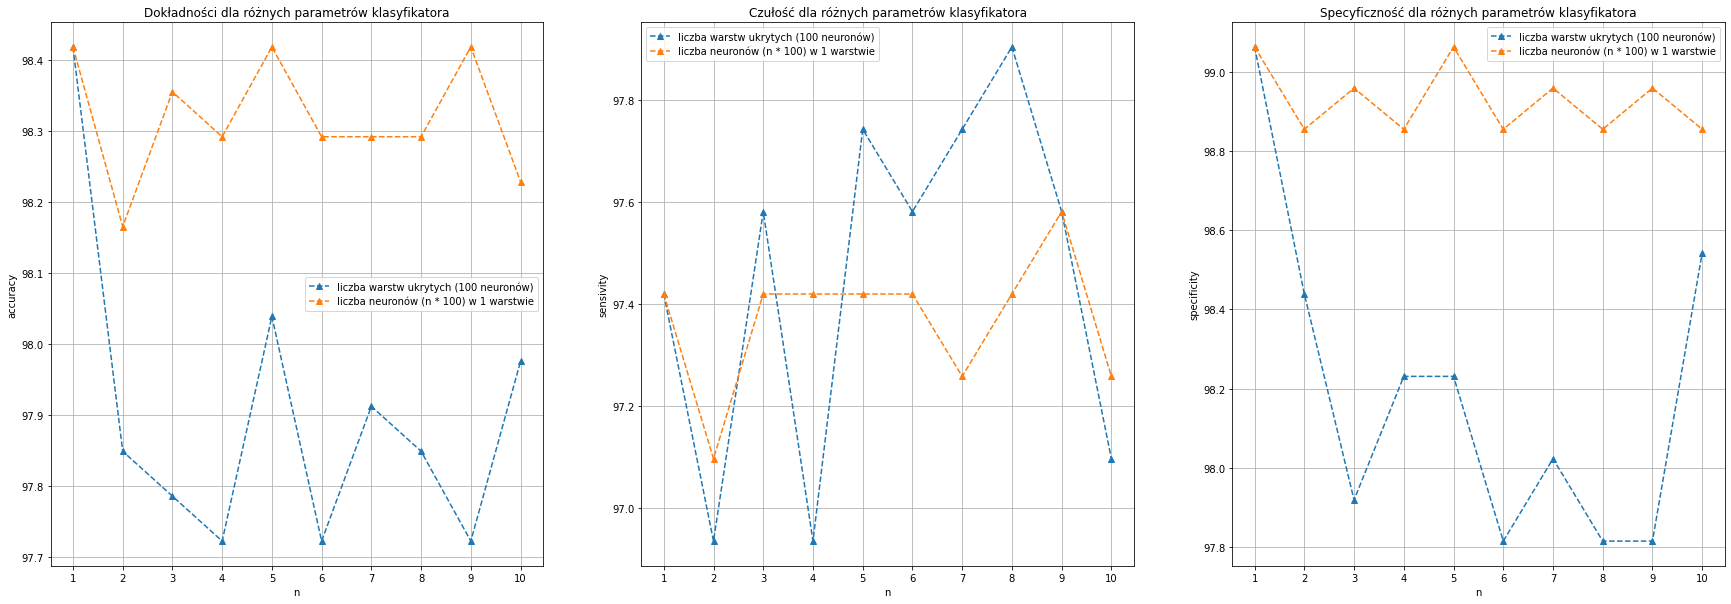

Max values for number of hidden layers (100 neurons)
Max accuracy: 98.419%
Max sensivity: 97.903%
Max specificity: 99.063%
Max values for number of neurons
Max accuracy: 98.419%
Max sensivity: 97.581%
Max specificity: 99.063%


In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(30,10))

def plot_grouped_stats(ax, stats, stat_name):
    ax.plot(common_range, stats[0][stat_name], label="liczba warstw ukrytych (100 neuronów)", **plot_style)
    ax.plot(common_range, stats[1][stat_name], label="liczba neuronów (n * 100) w 1 warstwie", **plot_style)
    ax.grid(b=True)
    ax.legend()

for i,stat_name in enumerate(["accuracy", "sensitivity", "specificity"]):
    plot_grouped_stats(axs[i], grouped_stats_dfs, stat_name)

axs[0].set(xlabel='n', ylabel='accuracy',
        title='Dokładności dla różnych parametrów klasyfikatora')
axs[1].set(xlabel='n', ylabel='sensivity',
        title='Czułość dla różnych parametrów klasyfikatora')
axs[2].set(xlabel='n', ylabel='specificity',
        title='Specyficzność dla różnych parametrów klasyfikatora')

loc = plticker.MultipleLocator(base=1.0)
for ax in axs:
    ax.xaxis.set_major_locator(loc)

plt.show()

for i,stat_df in enumerate(grouped_stats_dfs):
    if i == 0:
        print("Max values for number of hidden layers (100 neurons)")
    elif i == 1:
        print("Max values for number of neurons")
    print_max_stats(stat_df)

In [ ]:
from IPython.display import display

display(statistics_hidden_layers_df)
display(statistics_n_neurons_df)

,Number of hidden layers (100 neurons),accuracy,sensitivity,specificity,FNR,FPR
0,1,98.418722,97.419355,99.063476,2.580645,0.936524
1,2,97.849462,96.935484,98.439126,3.064516,1.560874
2,3,97.786211,97.580645,97.918835,2.419355,2.081165
3,4,97.722960,96.935484,98.231009,3.064516,1.768991
4,5,98.039216,97.741935,98.231009,2.258065,1.768991
5,6,97.722960,97.580645,97.814776,2.419355,2.185224
6,7,97.912713,97.741935,98.022893,2.258065,1.977107
7,8,97.849462,97.903226,97.814776,2.096774,2.185224
8,9,97.722960,97.580645,97.814776,2.419355,2.185224
9,10,97.975965,97.096774,98.543184,2.903226,1.456816


,Number of neurons in one hidden layer,accuracy,sensitivity,specificity,FNR,FPR
0,100,98.418722,97.419355,99.063476,2.580645,0.936524
1,200,98.165718,97.096774,98.855359,2.903226,1.144641
2,300,98.355471,97.419355,98.959417,2.580645,1.040583
3,400,98.292220,97.419355,98.855359,2.580645,1.144641
4,500,98.418722,97.419355,99.063476,2.580645,0.936524
5,600,98.292220,97.419355,98.855359,2.580645,1.144641
6,700,98.292220,97.258065,98.959417,2.741935,1.040583
7,800,98.292220,97.419355,98.855359,2.580645,1.144641
8,900,98.418722,97.580645,98.959417,2.419355,1.040583
9,1000,98.228969,97.258065,98.855359,2.741935,1.144641


##### Wnioski

* Bazowa wersja klasyfikatora z jedną warstwą i 100 neuronami osiąga najlepsze wyniki.
* Zwiększając liczbę wartstw ukrytych możemy polepszać skokowo czułość klasyfikatora ale odbywa się to kosztem dokładności i specyficzności.
* Zwiększanie liczby neuronów w warstwie nie przynosi lepszych rezultatów i wartość 100 wydaje się być optymalną z pośród wszystkich zbadanych.

##### Funkcja aktywacji

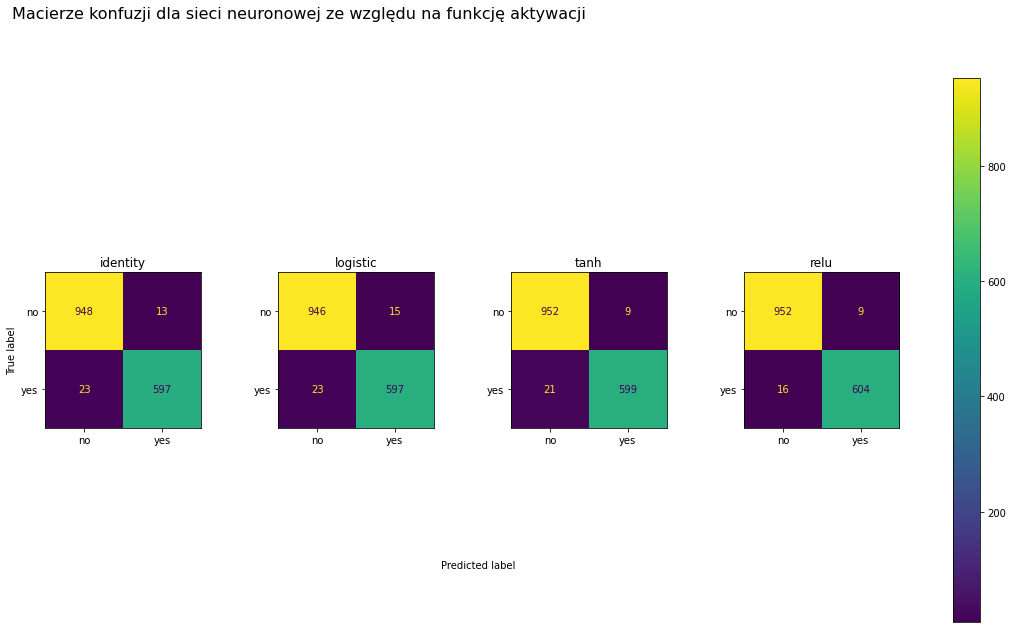

,name,accuracy,sensitivity,specificity,FNR,FPR
0,identity,97.722960,96.290323,98.647242,3.709677,1.352758
1,logistic,97.596458,96.290323,98.439126,3.709677,1.560874
2,tanh,98.102467,96.612903,99.063476,3.387097,0.936524
3,relu,98.418722,97.419355,99.063476,2.580645,0.936524


In [ ]:
activation_functions = ['identity', 'logistic', 'tanh', 'relu']

classifiers_stats = []

f, axes = plt.subplots(1, len(activation_functions), figsize=(20, 10))

for i, activation_function in enumerate(activation_functions):
    y_pred = run_mlp(X_train, X_test, y_train, activation=activation_function)
    disp = plot_confusion_matrix(y_test,y_pred,activation_function,classifiers_stats,["no","yes"],axes[i],i)

classifiers_stats_df = pd.DataFrame(classifiers_stats)

f.text(0.4, 0.2, 'Predicted label', ha='left')
f.colorbar(disp.im_, ax=axes)
f.suptitle('Macierze konfuzji dla sieci neuronowej ze względu na funkcję aktywacji', fontsize=16, ha="right")
plt.show()
classifiers_stats_df

##### Wnioski

* Domyślna funkcja aktywacji relu pozwala na uzyskanie najlepszych parametrów.
* Tangens hiperboliczny również pozwala na dobrą klasyfikację, lecz sieć popełnia więcej błędów podczas decyzji dla próbek, które są spamem.
* Pozostałe funkcje aktywacji nie przynoszą tak dobrych rezultatów.

#### Selekcja cech

#### Metoda multivariate RFECV i Forward feature selection

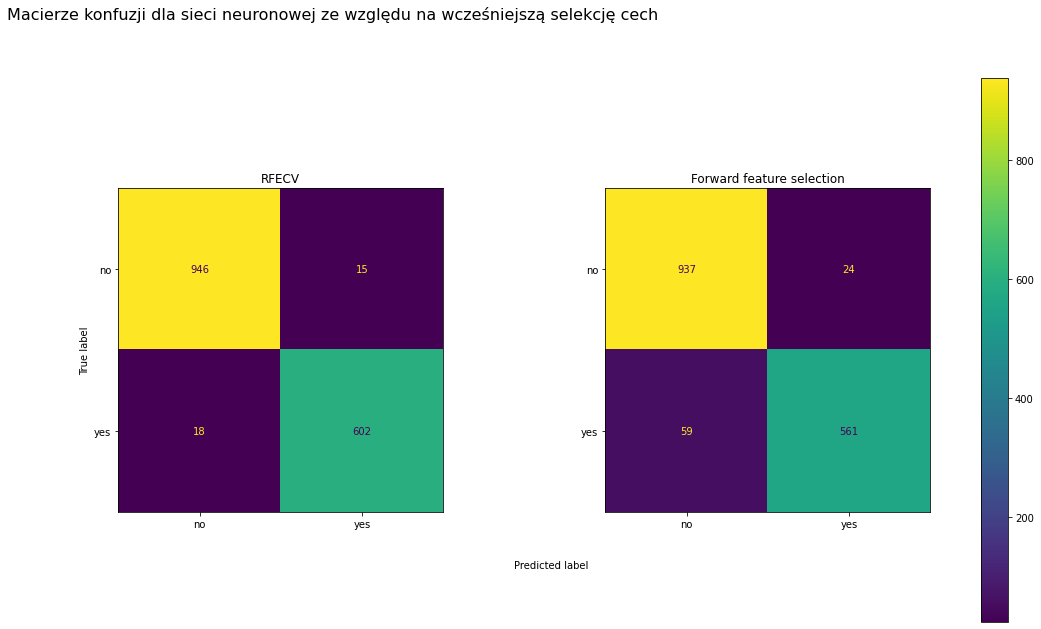

,Feature selection method,accuracy,sensitivity,specificity,FNR,FPR
0,RFECV,97.912713,97.096774,98.439126,2.903226,1.560874
1,Forward feature selection,94.750158,90.483871,97.502601,9.516129,2.497399


In [ ]:
classifiers_stats = []

f, axes = plt.subplots(1, 2, figsize=(20, 10))

for i, (name,dataset) in enumerate(reduced_datasets.items()):
    X_train_dataset, X_test_dataset, y_train_dataset, y_test_dataset = dataset
    y_pred = run_mlp(X_train_dataset, X_test_dataset, y_train_dataset)
    disp = plot_confusion_matrix(y_test_dataset,y_pred,name,classifiers_stats,["no","yes"],axes[i],i)

classifiers_stats_df = pd.DataFrame(classifiers_stats)
classifiers_stats_df.rename(columns={'name':'Feature selection method'}, inplace=True)

f.text(0.4, 0.2, 'Predicted label', ha='left')
f.colorbar(disp.im_, ax=axes)
f.suptitle('Macierze konfuzji dla sieci neuronowej ze względu na wcześniejszą selekcję cech', fontsize=16, ha="right")
plt.show()
classifiers_stats_df

#### Metoda PCA

In [ ]:
pca_stats = []

for (pca_size,pca_dataset) in pca_datasets.items():
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = pca_dataset
    y_pred = run_mlp(X_train_pca, X_test_pca, y_train_pca)
    stats = calculate_statistics(y_test_pca,y_pred)
    pca_model_data = StatistictsData(pca_size,*stats)
    pca_stats.append(pca_model_data)

pca_stats_df = pd.DataFrame(pca_stats)
pca_stats_df.rename(columns={'name':'Number of features'}, inplace=True)

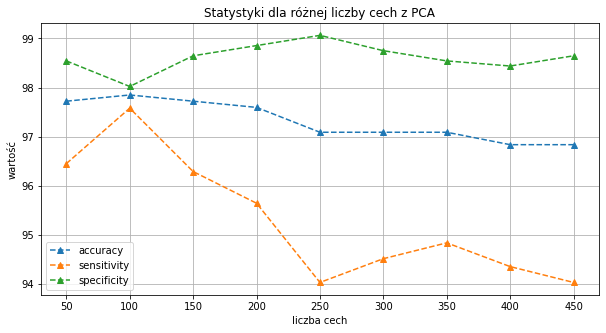

Max accuracy: 97.849%
Max sensivity: 97.581%
Max specificity: 99.063%


,Number of features,accuracy,sensitivity,specificity,FNR,FPR
0,50,97.722960,96.451613,98.543184,3.548387,1.456816
1,100,97.849462,97.580645,98.022893,2.419355,1.977107
2,150,97.722960,96.290323,98.647242,3.709677,1.352758
3,200,97.596458,95.645161,98.855359,4.354839,1.144641
4,250,97.090449,94.032258,99.063476,5.967742,0.936524
5,300,97.090449,94.516129,98.751301,5.483871,1.248699
6,350,97.090449,94.838710,98.543184,5.161290,1.456816
7,400,96.837445,94.354839,98.439126,5.645161,1.560874
8,450,96.837445,94.032258,98.647242,5.967742,1.352758


In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

plot_stats(ax,sizes,pca_stats_df,50.0)

ax.set(xlabel='liczba cech', ylabel='wartość',
       title='Statystyki dla różnej liczby cech z PCA')

plt.show()
print_max_stats(pca_stats_df)
pca_stats_df

##### Wnioski

* Wykonanie klasyfikacji na zredukowanej liczbcie cech dla każdej metody dało gorsze rezultaty niż uczenie na całym zbiorze danych.
* Sieci neuronowe uczyły się znacznie szybciej po redukcji wymiarów.
* Dla metody PCA wraz z wzrostem wymiarów do których redukujemy zbiór danych specyficzność rośnie, natomiast dokładność i czułość maleją.

#### Równoważenie treningowego zbioru danych

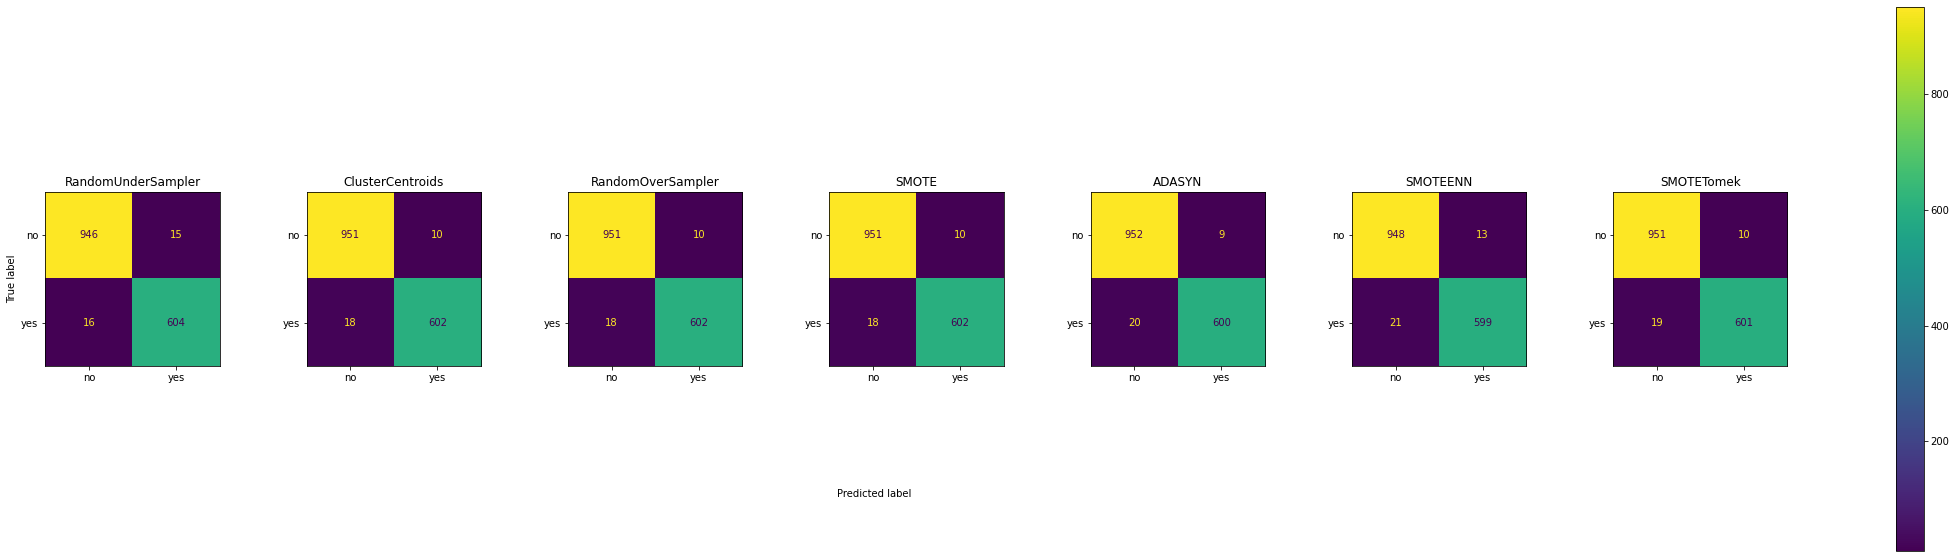

,name,accuracy,sensitivity,specificity,FNR,FPR
0,RandomUnderSampler,98.039216,97.419355,98.439126,2.580645,1.560874
1,ClusterCentroids,98.228969,97.096774,98.959417,2.903226,1.040583
2,RandomOverSampler,98.228969,97.096774,98.959417,2.903226,1.040583
3,SMOTE,98.228969,97.096774,98.959417,2.903226,1.040583
4,ADASYN,98.165718,96.774194,99.063476,3.225806,0.936524
5,SMOTEENN,97.849462,96.612903,98.647242,3.387097,1.352758
6,SMOTETomek,98.165718,96.935484,98.959417,3.064516,1.040583


In [ ]:
samplers_stats = []

f, axes = plt.subplots(1, len(sampled_datasets), figsize=(40, 10))

for i, (key, dataset) in enumerate(sampled_datasets.items()):
    X_train_under, y_train_under = dataset
    y_pred = run_mlp(X_train_under, X_test, y_train_under)
    disp = plot_confusion_matrix(y_test,y_pred,key,samplers_stats,["no", "yes"],axes[i],i)

samplers_stats_df = pd.DataFrame(samplers_stats)

f.text(0.4, 0.2, 'Predicted label', ha='left')

f.colorbar(disp.im_, ax=axes)
plt.show()
samplers_stats_df

##### Wnioski

* Równoważenie zbioru danych nie daje tak dobrych rezultatów dla sieci neuronowej jak lasu losowego.
* Najlepszy wynik uzyskanko dla metody ADASYN lecz podczas klasyfikacji wystąpiło więcej błędów 'yes' -> 'no' niż na niezmodyfikowanym zbiorze danych.
* Statystycznie lepsze wyniki uzyskiwano dla metod typu over sampling.

#### Niesymetryczne koszty błędu

Dla klasyfikatora sieci neuronowej z biblioteki scikit-learn nie zaimplementowano możliwości definiowania wagi klas podczas klasyfikacji.

Koszt błędów zależy po części od stosunku próbek w zbiorze uczącym, więc analiza ta został przeprowadzona w poprzednim punkcie.

#### Składanie modeli

W klasyfikatorze MLP nie zaimplementowano możliwości przypisywania wag próbkom podczsa uczenia dlatego nie może on zostać wykorzystany do składania wielu modeli przy pomocy algorytu Adaboost. Zamiast tego wykorzystano metodę polepszania klasyfikatorów (boosting) - bagging.

In [ ]:
from sklearn.ensemble import BaggingClassifier

statistics_bagging = []
clf_range = range(10, 51, 10)

for n_mlp in clf_range:
    clf = BaggingClassifier(base_estimator=MLPClassifier(random_state=0),
                            n_estimators=n_mlp, random_state=0, n_jobs=-1)
    y_pred_bagging = clf.fit(X_train, y_train).predict(X_test)
    stats = calculate_statistics(y_test, y_pred_bagging)
    clf_stats = StatistictsData(n_mlp,*stats)
    statistics_bagging.append(clf_stats)

statistics_bagging_df = pd.DataFrame(statistics_bagging)
statistics_bagging_df.rename(columns={'name':'Number of neural networks'}, inplace=True)

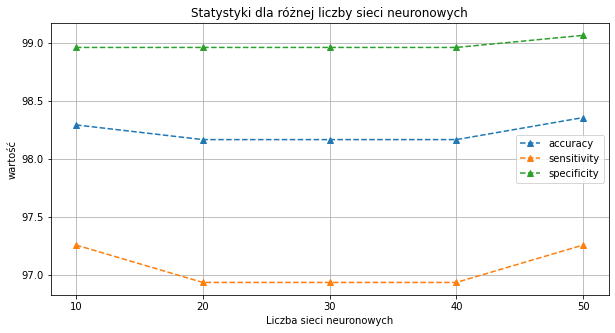

Max accuracy: 98.355%
Max sensivity: 97.258%
Max specificity: 99.063%


,Number of neural networks,accuracy,sensitivity,specificity,FNR,FPR
0,10,98.292220,97.258065,98.959417,2.741935,1.040583
1,20,98.165718,96.935484,98.959417,3.064516,1.040583
2,30,98.165718,96.935484,98.959417,3.064516,1.040583
3,40,98.165718,96.935484,98.959417,3.064516,1.040583
4,50,98.355471,97.258065,99.063476,2.741935,0.936524


In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

plot_stats(ax,clf_range,statistics_bagging_df,10.0)

ax.set(xlabel='Liczba sieci neuronowych', ylabel='wartość',
       title='Statystyki dla różnej liczby sieci neuronowych')

plt.show()
print_max_stats(statistics_bagging_df)
statistics_bagging_df

##### Wnioski

* Składanie sieci neuronowych nie przynosi znacznie lepszego efektu niż podstawowa wersja modelu.
* Zastosowanie 10 lub 50 sieci pozwala nam zwiększyć czułość i dokładność modelu nie tracąc specyficzności.

## Wariacje danych/parametrów/algorytmów - próba uzyskania modelu z FPR na poziomie 0.5%

Poniżej przeprowadzono niepełne analizy w celu próby uzyskania najlepszego klasyfikatora, które modyfikowały różne z parametrów na bazie wyników poprzednich badań.


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

def custom_recall_loss(y, y_pred):
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    fnr = fn / (fn + tp) * 100
    fpr = fp / (fp + tn) * 100
    if fpr > 0.5:
        return 1e10 # punish if exceeded threshold
    else:
        return fnr # we want to have fnr as low as possible

custom_scorer = make_scorer(custom_recall_loss, greater_is_better=False)

Funkcja `custom_recall_loss` została utworzona aby zagwarantować postawiony w zadaniu warunek o akceptowalności klasyfikatora, który jako próg przyjmował wartość 0.5%. Funkcja dla predykcji na zbiorze treningowym, które przekraczają ten próg zwraca znacznie większą wartość, natomiast gdy warunek jest spełniony zwraca parametr FNR. Algorytm GridSearchCV po ewaluacji wszystkich modeli wybierze estymator, który spełniał próg FPR oraz miał minimalną wartość FNR.

In [ ]:
from sklearn.cluster import KMeans
from imblearn.under_sampling import ClusterCentroids

# dataset for random forest
kmeans = KMeans(random_state=0, n_init=5, max_iter=150)
X_train_under, y_train_under = ClusterCentroids(random_state=0, estimator=kmeans).fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/imblearn/under_sampling/_prototype_generation/_cluster_centroids.py:172: ConvergenceWarning: Number of distinct clusters (766) found smaller than n_clusters (1220). Possibly due to duplicate points in X.
  self.estimator_.fit(_safe_indexing(X, target_class_indices))


### Las losowy

#### Model łączący parametry z poprzednich analiz

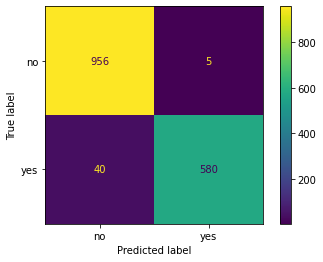

accuracy = 97.15%
sensitivity = 93.55%
specificity = 99.48%
FNR = 6.45%
FPR = 0.52%


In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest_clf = RandomForestClassifier(random_state=0, criterion="entropy", max_depth=7)

y_pred = random_forest_clf.fit(X_train_under, y_train_under).predict(X_test)

calculate_statistics(y_test, y_pred, True)

#### Grid search z własną funkcją oceny analizujący zestawy różnych parametrów

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'max_depth': [None,5,7,15,20],
    'criterion': ['gini', 'entropy'],
    'max_features': ["sqrt", "log2", 15, 20],
    'n_estimators': [50, 100, 150, 200],
    'min_samples_split': [2,10,50],
    'bootstrap': [False, True]
}

random_forest_clf = RandomForestClassifier(random_state=0)

model_gridsearch_rf = GridSearchCV(
    estimator=random_forest_clf,
    param_grid=param_grid,
    scoring=custom_scorer,
    n_jobs=-1,
    cv=5,
    refit=True
)

model_gridsearch_rf.fit(X_train_under, y_train_under)
print(f"Best found estimator\n{model_gridsearch_rf.best_estimator_}")

Best found estimator
RandomForestClassifier(bootstrap=False, max_depth=20, max_features='sqrt',
                       random_state=0)


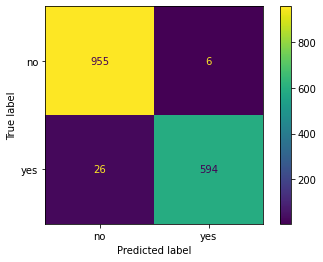

accuracy = 97.98%
sensitivity = 95.81%
specificity = 99.38%
FNR = 4.19%
FPR = 0.62%


In [ ]:
y_pred = model_gridsearch_rf.best_estimator_.predict(X_test)
calculate_statistics(y_test, y_pred, True)

### Wnioski

* Pierwszy utworzony model lasu losowego na bazie analizy z poprzednich etapów osiągnął wartość bliską żądanemu poziomowi 0.52% FPR na zbiorze testowym, lecz przepuścił 40 wiadomości, które były spamem.
* Ewaulując modele z wykorzystaniem kombinacji parametrów przy pomocy GridSearchCV oraz własnej funkcji wyniku, uzyskano klasyfikator, który ma nieznacznie większy poziom FPR = 0.62% ale przepuszcza on o 14 mniej maili, które są spamem od pierwszego lasu losowego.
* Poszukiwanie modelu na bazie zadanych metryk FPR oraz FNR podczas ewaluacji na zbiorze treningowym nie musi przekładać się na dobre wartości tych zmiennych na zbiorze testowym.

### Sieć neuronowa

#### Model łączący parametry z poprzednich analiz

Dla sieci neuronowej najlepszym modelem okazała się podstawowa wersja sieci na domyślnym zbiorze treningowym.

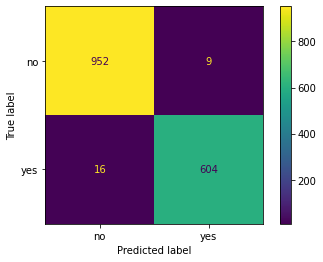

accuracy = 98.42%
sensitivity = 97.42%
specificity = 99.06%
FNR = 2.58%
FPR = 0.94%


In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(random_state=0)

y_pred = mlp_clf.fit(X_train, y_train).predict(X_test)
calculate_statistics(y_test, y_pred, True)

##### Wizualizacja zbioru testowego sklasyfikowanego przez sieć

In [ ]:
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.neural_network import MLPClassifier
import numpy as np

def get_activations(clf, X):
    """ Function to extract outputs of hidden layers from MLP classifier """
    hidden_layer_sizes = clf.hidden_layer_sizes
    if not hasattr(hidden_layer_sizes, "__iter__"):
        hidden_layer_sizes = [hidden_layer_sizes]
    hidden_layer_sizes = list(hidden_layer_sizes)
    layer_units = [X.shape[1]] + hidden_layer_sizes + \
        [clf.n_outputs_]
    activations = [X]
    for i in range(clf.n_layers_ - 1):
        activations.append(np.empty((X.shape[0],
                                        layer_units[i + 1])))
    clf._forward_pass(activations)
    return activations

mlp_clf = MLPClassifier(random_state=0)
mlp_clf.fit(X_train, y_train)

pooled_outputs = get_activations(mlp_clf, X_test.to_numpy())

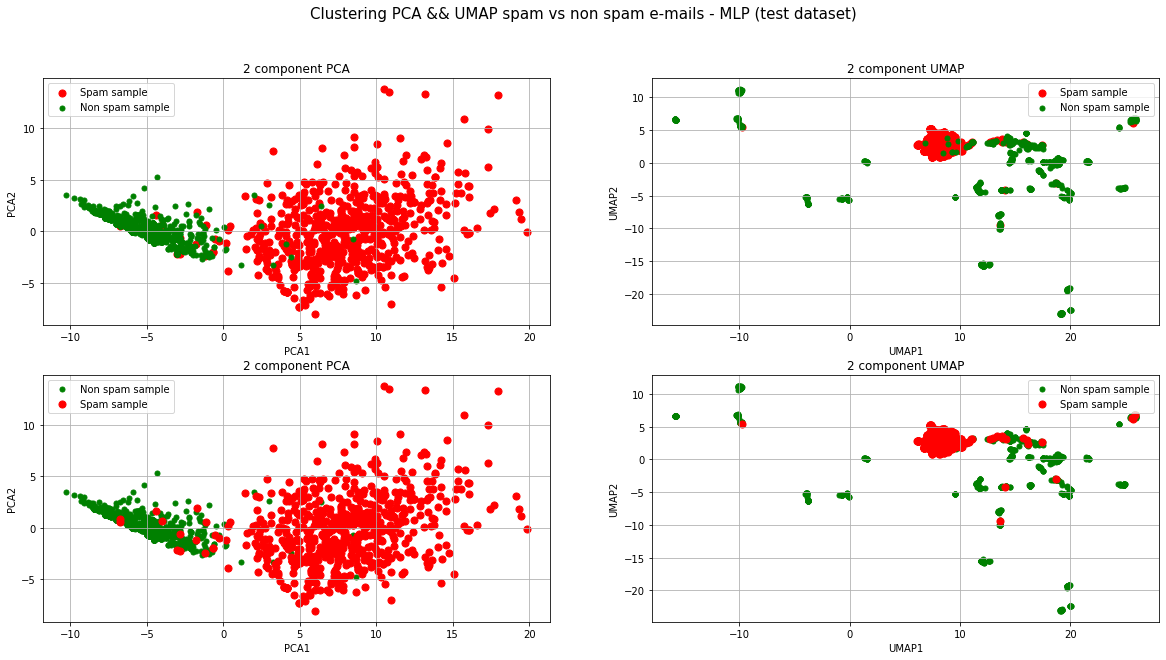

In [ ]:
import umap
from sklearn.decomposition import PCA

pca_components=2
umap_components=2

pca_model = PCA(n_components=pca_components)
umap_model = umap.UMAP(n_components=umap_components)

hidden_layer_outputs = pooled_outputs[1]

pca_result = pca_model.fit_transform(hidden_layer_outputs)
umap_result = umap_model.fit_transform(hidden_layer_outputs)

#convert to pandas df with class labels added
y_test_df = pd.DataFrame(y_test).reset_index(drop=True)
pca_result_df = pd.DataFrame(data=pca_result, columns = ['DIM1', 'DIM2'])
pca_result_df = pd.concat([pca_result_df, y_test_df], axis=1)
umap_result_df = pd.DataFrame(data=umap_result, columns = ['DIM1', 'DIM2'])
umap_result_df = pd.concat([umap_result_df, y_test_df], axis=1)

print_pca_umap(pca_result_df,umap_result_df,"Clustering PCA && UMAP spam vs non spam e-mails - MLP (test dataset)")

##### Wnioski

* W porównaniu do początkowej wizualizacji całego zbioru danych, widzimy, że cząstkowe wyniki z sieci neuronowej poddane redukcji z wykorzystaniem algorytmów PCA i UMAP pozwalają obu metodą dobrze odseparować od siebie przeciwstawne dane.
* Porównują górne wykresy z dolnymi, widzimi, że ilość próbek, która na siebie nachodzi jest niewielka i odpowiada wartościom FNR i FPR z macierzy konfuzji modelu sieci dla której wykreślono klasyfikację na zbiorze testowym.

#### Grid search z własną funkcją oceny analizujący zestawy różnych parametrów

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

param_grid = {
    'hidden_layer_sizes': [(100,), (200,), (200,300,400), (100, 50, 25), (50, 50, 50), (100,) * 9],
    'activation': ['relu', 'tanh']
}

mlp_clf = MLPClassifier(random_state=0)

model_gridsearch_mlp = GridSearchCV(
    estimator=mlp_clf,
    param_grid=param_grid,
    scoring=custom_scorer,
    cv=5,
    n_jobs=-1,
    refit=True
)

model_gridsearch_mlp.fit(X_train, y_train)
print(f"Best found estimator\n{model_gridsearch_mlp.best_estimator_}")

Best found estimator
MLPClassifier(hidden_layer_sizes=(200,), random_state=0)


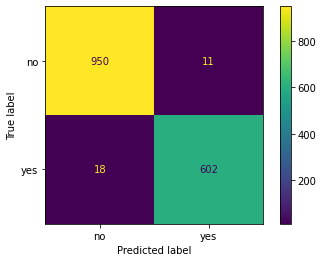

accuracy = 98.17%
sensitivity = 97.10%
specificity = 98.86%
FNR = 2.90%
FPR = 1.14%


In [ ]:
y_pred = model_gridsearch_mlp.best_estimator_.predict(X_test)
calculate_statistics(y_test, y_pred, True)

### Wnioski

* Żaden z utworzonych modeli nie osiągnął na zbiorze testowym żądanego poziomu 0.5% FPR, pomimo spełnienia tego warunku na danych treningowych.
* Modyfikacja ilości oraz wielkości warstw w sieci neuronowej dokonana przy użyciu algorytmu GridSearchCV, pozwoliła znaleźć tylko kilka modeli które spełniały kryterium badań, lecz ich wyniki na zbiorze testowym są nadal gorsze od lasu losowego.
* Poszukiwanie modelu na bazie zadanych metryk FPR oraz FNR podczas ewaluacji na zbiorze treningowym nie musi przekładać się na dobre wartości tych zmiennych na zbiorze testowym.